In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 9.1 Import required dependencies and modules

In [ ]:
import zipfile
import os
import random
import string

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.data import Dataset
from tensorflow.keras.layers import Conv1D, Input, Dense, LSTM, Bidirectional, Concatenate, Dropout, GlobalMaxPool1D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

## 9.2 Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -a "/content/drive/MyDrive/Major Project/saved_models/skimlit_tribrid_model" "/content/drive/MyDrive/Major Project/saved_models/copy_skimlit_tribrid_model"

In [ ]:
!cp -a "/content/drive/MyDrive/Major Project/saved_models/model_5" "/content/drive/MyDrive/Major Project/saved_models/copy_model_5"

## 9.3 Download Dataset from GitHub and move to GDrive

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 27.43 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced with '@' sign
data_dir = "/content/drive/MyDrive/Major Project/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check what files are in the PubMed_20K dataset
!ls "/content/drive/MyDrive/Major Project/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

dev.txt  test.txt  train.txt


In [ ]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/drive/MyDrive/Major Project/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/drive/MyDrive/Major Project/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/drive/MyDrive/Major Project/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## 9.4 Define Helper Functions

In [ ]:
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [ ]:
def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results

In [ ]:
def get_lines(filename):
    with open(filename, "r") as file:
        return file.readlines()

In [ ]:
def split_chars(text):
    return " ".join(list(text))

In [ ]:
def preprocess_text_with_line_numbers(filename):

    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)

        else:
            abstract_lines += line

    return abstract_samples

## 9.5 Preprocess data

```
[{"line_number": 0,
   "target": "BACKGROUND",
   "text": "Emotional eating is associated with overeating and the development of obesity .\n",
   "total_lines": 11},
   ...]
```

In [ ]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 636 ms, sys: 185 ms, total: 821 ms
Wall time: 2.6 s


In [ ]:
# Checking the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df["target"].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

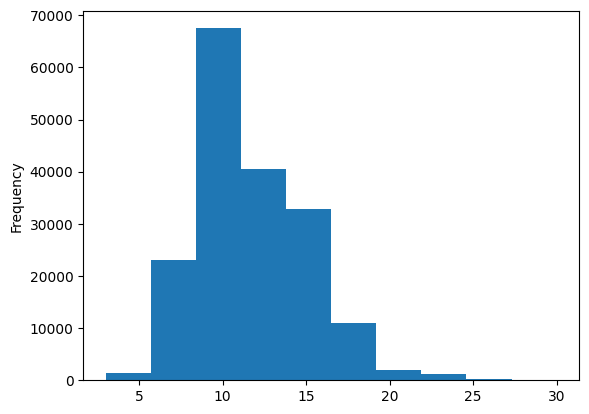

In [ ]:
# checking the length of different lines
train_df["total_lines"].plot.hist();

In [ ]:
# Converting abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# Viewing the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
#lenght of each sentence
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_length = np.mean(sent_lens)
avg_sent_length

26.338269273494777

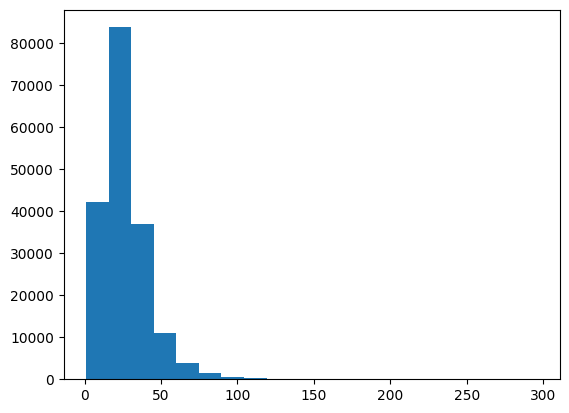

In [ ]:
#distribution
plt.hist(sent_lens, bins=20);

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

In [ ]:
# How many words are in our vocabulary? (taken from table 2 in: https://arxiv.orf/pdf/1710.06071.pdf)
max_tokens = 68000

### Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

#### Create text vectorizer layer

We want to make a layer which maps our words to numbers.

In [ ]:
# Create a text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens,  # number of words in vocab
                                    output_sequence_length=output_seq_len)  # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
laparoscopic surgery in experienced hands is safe and feasible first-line treatment for appendiceal abscess .

Length of text: 15

Vectorized text: [[  723   115     5   581  5137    20   514     3  1099  1368    19    11
  23865  6446     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


#### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = Embedding(input_dim=len(rct_20k_text_vocab),
                        output_dim=128,
                        mask_zero=True,
                        name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
print(f"Vectorized sentence shape:{vectorized_sentence.shape}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape:{embedded_sentence.shape}")

Sentence before vectorization:
laparoscopic surgery in experienced hands is safe and feasible first-line treatment for appendiceal abscess .

Sentence after vectorization (before embedding):
[[  723   115     5   581  5137    20   514     3  1099  1368    19    11
  23865  6446     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Vectorized sentence shape:(1, 55)

Sentence after embedding:
[[[ 0.0111024   0.03629379  0.00616794 ... -0.01969584  0.04752126
   -0.00509782]
  [-0.01354349 -0.00536247 -0.04893097 ... -0.0158545   0.02715224
   -0.00207294]
  [-0.00313437  0.00055999 -0.00366591 ...  0.03214287 -0.03792671
    0.00779406]
  ...
  [-0.01060548  0.04406817  0.00669596 ... -0.01518895 -0.00205182
    0.01965605]
  [-0.01060548  0.04406817  0.00669596 ... -0.01518895 -0.00205182


## 9.5 Make numeric labels (ML models require numeric labels)

In [ ]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# checking what one hot encoded labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Extracting labels ("target" columns) and encode them into integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Checking what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Getting class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## 9.6 Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* [Data_Performance](https://www.tensorflow.org/guide/data_performance)
* [Input_Pipelines](https://www.tensorflow.org/guide/data)

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDatasets and prefetch them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## 9.7 Model 0: Getting a baseline

In [ ]:
# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## 9.8 Model 1: Conv1D with token embeddings

In [ ]:
# Create Conv1D model to process sequences
inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)  # vectorize text inputs
token_embeddings = token_embed(text_vectors)    # create embedding
x = Conv1D(64, 5, padding="same", activation="relu")(token_embeddings)
x = GlobalMaxPool1D()(x) # condense the output of our feature vector from conv layer
outputs = Dense(num_classes, activation="softmax")(x)
model_1 = Model(inputs, outputs)

In [ ]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                             

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=len(train_dataset),
                              epochs=10,
                              validation_data=valid_dataset,
                              validation_steps=len(valid_dataset))

Epoch 1/10
5627/5627 [==============================] - 64s 11ms/step - loss: 0.5497 - accuracy: 0.7979 - val_loss: 0.4837 - val_accuracy: 0.8208
Epoch 2/10
5627/5627 [==============================] - 38s 7ms/step - loss: 0.3584 - accuracy: 0.8731 - val_loss: 0.5270 - val_accuracy: 0.8126
Epoch 3/10
5627/5627 [==============================] - 38s 7ms/step - loss: 0.2153 - accuracy: 0.9300 - val_loss: 0.6130 - val_accuracy: 0.8039
Epoch 4/10
5627/5627 [==============================] - 38s 7ms/step - loss: 0.1121 - accuracy: 0.9674 - val_loss: 0.7391 - val_accuracy: 0.7957
Epoch 5/10
5627/5627 [==============================] - 39s 7ms/step - loss: 0.0584 - accuracy: 0.9843 - val_loss: 0.9027 - val_accuracy: 0.7915
Epoch 6/10
5627/5627 [==============================] - 38s 7ms/step - loss: 0.0358 - accuracy: 0.9905 - val_loss: 1.0628 - val_accuracy: 0.7894
Epoch 7/10
5627/5627 [==============================] - 38s 7ms/step - loss: 0.0269 - accuracy: 0.9928 - val_loss: 1.2100 - val_a

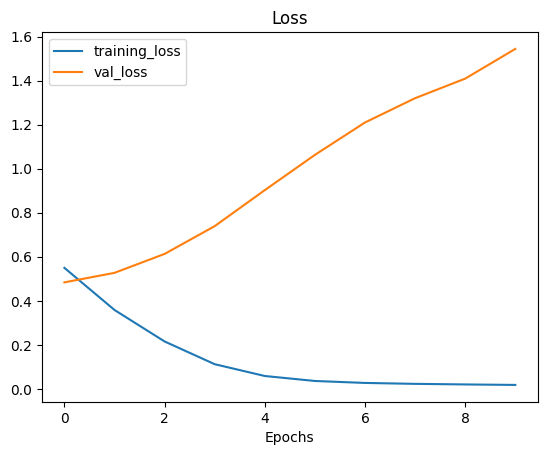

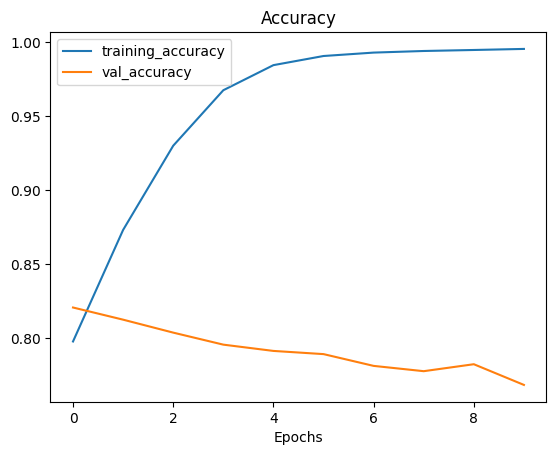

In [ ]:
plot_loss_curves(history_model_1)

In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 1.5441 - accuracy: 0.7686


[1.544090747833252, 0.768568754196167]

In [ ]:
# Make predictions (our model predicts prediction probability for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[9.98487830e-01, 1.39573927e-03, 1.98875478e-06, 1.14353985e-04,
         6.44566640e-08],
        [9.96439874e-01, 2.78102925e-05, 8.68635663e-10, 3.53235728e-03,
         1.05566261e-12],
        [7.00704694e-01, 4.44233178e-10, 1.43064190e-13, 2.99295306e-01,
         2.57123656e-09],
        ...,
        [1.63545642e-12, 6.39007754e-14, 3.56684211e-08, 1.42202561e-13,
         1.00000000e+00],
        [1.75744006e-07, 7.97686260e-03, 3.37512307e-09, 3.26771860e-14,
         9.92022991e-01],
        [2.35985814e-10, 9.99998450e-01, 2.74614914e-10, 3.53745332e-15,
         1.50570168e-06]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 76.85687806169734,
 'precision': 0.7740849762982769,
 'recall': 0.7685687806169734,
 'f1': 0.7669817687914756}

## 9.9 Model 2: Feature Extraction with Pretrained Token Embeddings



In [ ]:
# Download pretrained TensorFlow Hub USE
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
domestic piglets ( n = @ ) .
Sentence after embedding:
[ 0.05809489 -0.05305844  0.02504842 -0.02185507 -0.01098503  0.05209717
  0.05331462  0.03287273 -0.07027377 -0.01795324  0.04445014  0.08127385
  0.0105706   0.00613873 -0.05693806 -0.05288265 -0.06476965  0.01044992
 -0.07456265 -0.06006346  0.08631161  0.00450199  0.06748137 -0.00758422
  0.04057573 -0.04217574  0.05971335 -0.052568    0.01290405  0.03117867]

Length of sentence embedding: 512


### Building and fitting an NLP Feature Extraction model using Pretrained Embeddings from TensorFlow Hub

In [ ]:
# Define feature extraction model using
inputs = Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = Dense(128, activation="relu")(pretrained_embedding)
outputs = Dense(num_classes, activation="softmax")(x)
model_2 = Model(inputs, outputs, name="model_2_USE_feature_extractor")

In [ ]:
# Compiling the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fiting the model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=10,
                              steps_per_epoch=len(train_dataset),
                              validation_data=valid_dataset,
                              validation_steps=len(valid_dataset))

Epoch 1/10
5627/5627 [==============================] - 82s 14ms/step - loss: 0.7294 - accuracy: 0.7208 - val_loss: 0.6564 - val_accuracy: 0.7496
Epoch 2/10
5627/5627 [==============================] - 81s 14ms/step - loss: 0.6358 - accuracy: 0.7583 - val_loss: 0.6205 - val_accuracy: 0.7639
Epoch 3/10
5627/5627 [==============================] - 83s 15ms/step - loss: 0.6018 - accuracy: 0.7722 - val_loss: 0.6066 - val_accuracy: 0.7699
Epoch 4/10
5627/5627 [==============================] - 83s 15ms/step - loss: 0.5796 - accuracy: 0.7810 - val_loss: 0.6002 - val_accuracy: 0.7710
Epoch 5/10
5627/5627 [==============================] - 84s 15ms/step - loss: 0.5630 - accuracy: 0.7872 - val_loss: 0.5973 - val_accuracy: 0.7735
Epoch 6/10
5627/5627 [==============================] - 82s 15ms/step - loss: 0.5494 - accuracy: 0.7927 - val_loss: 0.5965 - val_accuracy: 0.7738
Epoch 7/10
5627/5627 [==============================] - 83s 15ms/step - loss: 0.5380 - accuracy: 0.7975 - val_loss: 0.5977 -

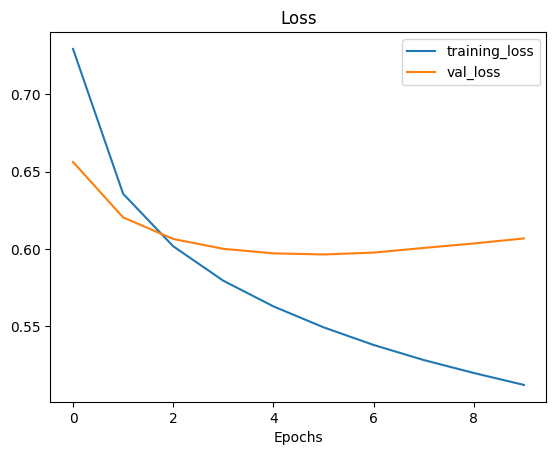

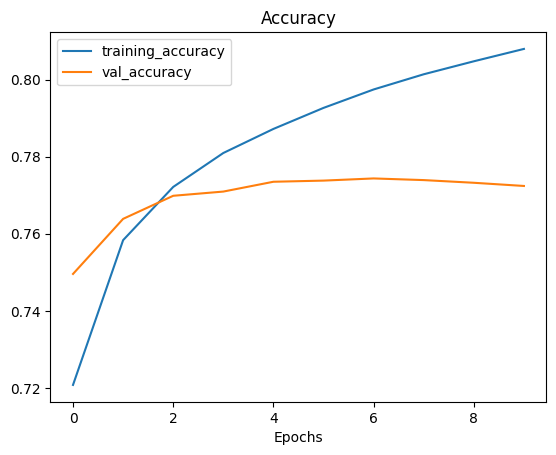

In [ ]:
plot_loss_curves(history_model_2)

In [ ]:
# Evaluating on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.6069 - accuracy: 0.7724


[0.6069218516349792, 0.7724083065986633]

In [ ]:
# Making predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 12ms/step


array([[6.68580413e-01, 2.36095041e-01, 3.53633295e-05, 9.40040573e-02,
        1.28510245e-03],
       [6.53659582e-01, 1.06370516e-01, 2.19820955e-04, 2.39548415e-01,
        2.01735515e-04],
       [5.26103795e-01, 2.85419077e-03, 8.70842766e-03, 4.61304516e-01,
        1.02910120e-03],
       ...,
       [5.41798763e-05, 3.36595986e-05, 1.74505345e-03, 1.43710868e-05,
        9.98152673e-01],
       [7.15900436e-02, 1.54629186e-01, 1.52840093e-01, 7.67345494e-03,
        6.13267183e-01],
       [2.49308324e-03, 9.97093081e-01, 2.96559127e-04, 1.67102075e-06,
        1.15643299e-04]], dtype=float32)

In [ ]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [ ]:
# Calculate results from TF Hub Pretrained Embedding on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.24083145769893,
 'precision': 0.7709709729546389,
 'recall': 0.7724083145769893,
 'f1': 0.7687080313387219}

## 9.10 Model 3: Character Embeddings

### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Test splitting a non-character-level sequence into characters
split_chars(random_train_sentence)

'd o m e s t i c   p i g l e t s   (   n   =   @   )   .'

In [ ]:
#
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
#
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

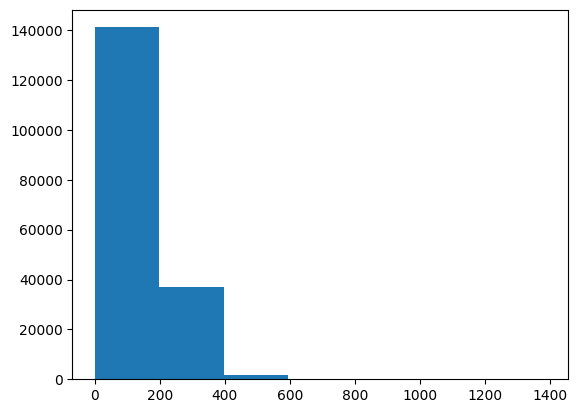

In [ ]:
# Check the distribution of our sequences at a character-level
plt.hist(char_lens, bins=7);

In [ ]:
#
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
#
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    # standardize=None, # set standarization to "None" if you want to leave punctuation on
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
#
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
#
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i n   c o n t r a s t   ,   t h e   c r i c   g r o u p   i n c r e a s e d   i n i t i a t i o n   o f   c r i c o t h y r o i d o t o m y   b u t   f a i l e d   t o   c h a n g e   p r a c t i c e   i n   s u p r a g l o t t i c   a i r w a y   .

Length of random_train_chars: 107

Vectorized chars:
[[ 4  6 11  7  6  3  8  5  9  3  3 13  2 11  8  4 11 18  8  7 16 14  4  6
  11  8  2  5  9  2 10  4  6  4  3  4  5  3  4  7  6  7 17 11  8  4 11  7
   3 13 19  8  7  4 10  7  3  7 15 19 22 16  3 17  5  4 12  2 10  3  7 11
  13  5  6 18  2 14  8  5 11  3  4 11  2  4  6  9 16 14  8  5 18 12  7  3
   3  4 11  5  4  8 20  5 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0 

### Creating a character-level embedding

In [ ]:
#
# Create char embedding layer
char_embed = Embedding(input_dim=len(char_vocab),   # number of different characters
                       output_dim=25,   # this is the size of char emebedding in the paper: https://arvix.org/pdf/1612.05251.pdf (Figure 1)
                       mask_zero=True,
                       name="char_embed")

In [ ]:
# Test out character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
i n   c o n t r a s t   ,   t h e   c r i c   g r o u p   i n c r e a s e d   i n i t i a t i o n   o f   c r i c o t h y r o i d o t o m y   b u t   f a i l e d   t o   c h a n g e   p r a c t i c e   i n   s u p r a g l o t t i c   a i r w a y   .

Embedded chars (after vectorization and embedding):
[[[-0.0098454  -0.00407015 -0.01576933 ... -0.0380532   0.03026228
   -0.02739214]
  [ 0.00021408  0.01393658 -0.01772489 ... -0.00257121  0.00265748
   -0.0450989 ]
  [ 0.03575379  0.02884812 -0.04577657 ...  0.01397374  0.01103103
   -0.01491723]
  ...
  [-0.04209839 -0.00798323 -0.01899682 ...  0.0420037   0.01324404
   -0.00601255]
  [-0.04209839 -0.00798323 -0.01899682 ...  0.0420037   0.01324404
   -0.00601255]
  [-0.04209839 -0.00798323 -0.01899682 ...  0.0420037   0.01324404
   -0.00601255]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = Conv1D(64, 5, padding="same", activation="relu")(char_embeddings)
x = GlobalMaxPool1D()(x)
outputs = Dense(num_classes, activation="softmax")(x)
model_3 = Model(inputs, outputs, name="model_3_conv1d_char_embeddings")

In [ ]:
# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                            #   steps_per_epoch=len(train_dataset),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 7s 8ms/step - loss: 1.2685 - accuracy: 0.4822 - val_loss: 1.0536 - val_accuracy: 0.5795
Epoch 2/5
562/562 [==============================] - 4s 7ms/step - loss: 1.0125 - accuracy: 0.5954 - val_loss: 0.9414 - val_accuracy: 0.6353
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 0.9267 - accuracy: 0.6381 - val_loss: 0.8696 - val_accuracy: 0.6712
Epoch 4/5
562/562 [==============================] - 4s 8ms/step - loss: 0.8733 - accuracy: 0.6645 - val_loss: 0.8439 - val_accuracy: 0.6729
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8580 - accuracy: 0.6697 - val_loss: 0.8190 - val_accuracy: 0.6885


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.21409117, 0.35292032, 0.06159348, 0.32328337, 0.04811165],
       [0.1496509 , 0.7224336 , 0.01379973, 0.10414376, 0.00997202],
       [0.09357825, 0.14739154, 0.32706156, 0.41483343, 0.01713524],
       ...,
       [0.03724939, 0.04669816, 0.12838307, 0.0159484 , 0.77172095],
       [0.02864326, 0.07991938, 0.43624607, 0.06646421, 0.38872713],
       [0.38423157, 0.49759018, 0.08571098, 0.02133736, 0.01112995]],
      dtype=float32)

In [ ]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 67.95313120614325,
 'precision': 0.6812548371716473,
 'recall': 0.6795313120614326,
 'f1': 0.6754559880660109}

## Model 4: Combining Pretrained Token Embeddings + Characters Embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_2`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers of top of 3 (similar to Figure 1 of section 4.2 of https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes a token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Concatenate, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

# 1. Setup token inputs/model
token_inputs = Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = Dense(128, activation="relu")(token_embeddings)
token_model = Model(token_inputs, token_output)

# 2. Setup char inputs/model
char_inputs = Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = Bidirectional(LSTM(24))(char_embeddings) # bi-LSTM shown in https://arxiv.org/pdf/1612.05251.pdf
char_model = Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = Concatenate(name="token_char_hybrid")([token_model.output,
                                                           char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = Dropout(0.5)(token_char_concat)
combined_dense = Dense(128, activation="relu")(combined_dropout)
final_dropout = Dropout(0.5)(combined_dense)
output_layer = Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = Model(inputs=[token_model.input, char_model.input],
                outputs=output_layer,
                name="model_4_token_and_char_embeddings")

In [ ]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

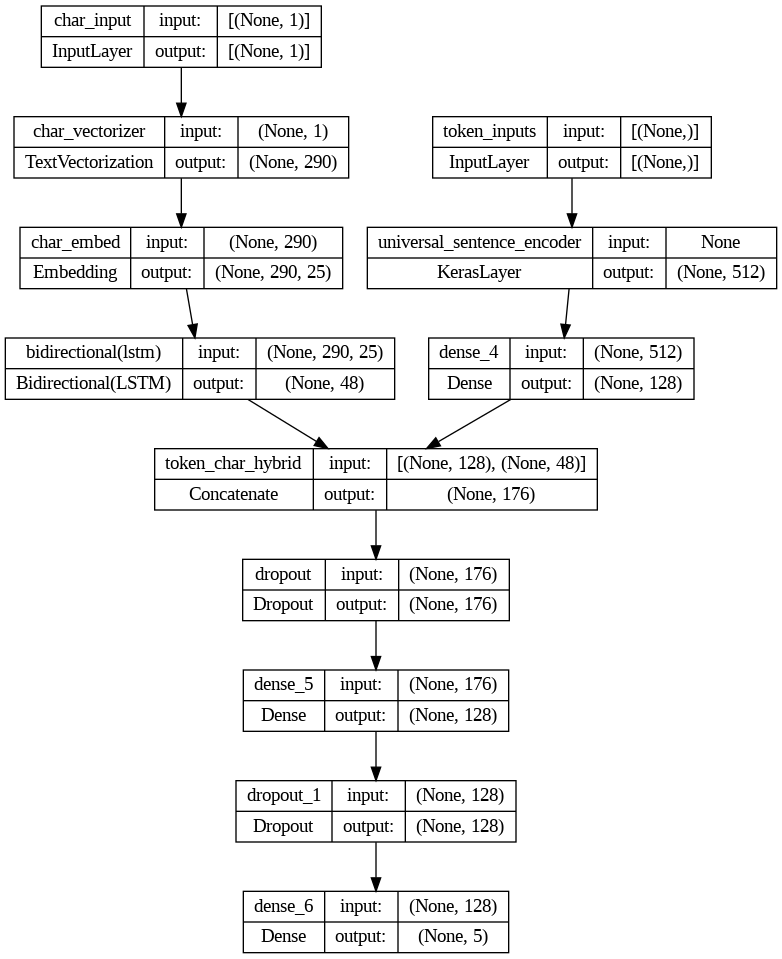

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [ ]:
#
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))  # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)  # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))    # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))  # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)  # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))    # combine data and labels

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#
# Same with the test data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))  # make data
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)  # make labels
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))    # combine data and labels

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                            #   steps_per_epoch=len(train_char_token_dataset),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 45s 57ms/step - loss: 0.9735 - accuracy: 0.6169 - val_loss: 0.7664 - val_accuracy: 0.7058
Epoch 2/5
562/562 [==============================] - 29s 51ms/step - loss: 0.7980 - accuracy: 0.6928 - val_loss: 0.7084 - val_accuracy: 0.7304
Epoch 3/5
562/562 [==============================] - 27s 48ms/step - loss: 0.7731 - accuracy: 0.7086 - val_loss: 0.6805 - val_accuracy: 0.7450
Epoch 4/5
562/562 [==============================] - 30s 54ms/step - loss: 0.7409 - accuracy: 0.7188 - val_loss: 0.6628 - val_accuracy: 0.7563
Epoch 5/5
562/562 [==============================] - 28s 50ms/step - loss: 0.7440 - accuracy: 0.7185 - val_loss: 0.6560 - val_accuracy: 0.7500


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.6643 - accuracy: 0.7454


[0.6643499732017517, 0.7453991770744324]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 25s 23ms/step


array([[5.6835330e-01, 2.0833991e-01, 5.5214050e-03, 2.1188234e-01,
        5.9029711e-03],
       [4.1050395e-01, 4.6065208e-01, 9.1086710e-03, 1.1666566e-01,
        3.0696299e-03],
       [3.7511075e-01, 7.1311407e-02, 6.6643372e-02, 4.5530993e-01,
        3.1624582e-02],
       ...,
       [2.0307259e-04, 2.6124422e-03, 6.4604968e-02, 1.3888805e-04,
        9.3244064e-01],
       [2.7878685e-03, 2.1049203e-02, 4.8798373e-01, 1.7109382e-03,
        4.8646826e-01],
       [2.6338533e-01, 4.0532088e-01, 2.9138657e-01, 1.1087929e-02,
        2.8819313e-02]], dtype=float32)

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 2, 1])>

In [ ]:
# Calculate results of token-char hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 74.53991791341188,
 'precision': 0.7438148109704772,
 'recall': 0.7453991791341189,
 'f1': 0.7394218757333942}

## Model 5: Transfer Learning with Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **🔑 Note:** Any engineered features used to train a model must be available at test time. In our case, line numbers and total lines are available.

### Create Positional Embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

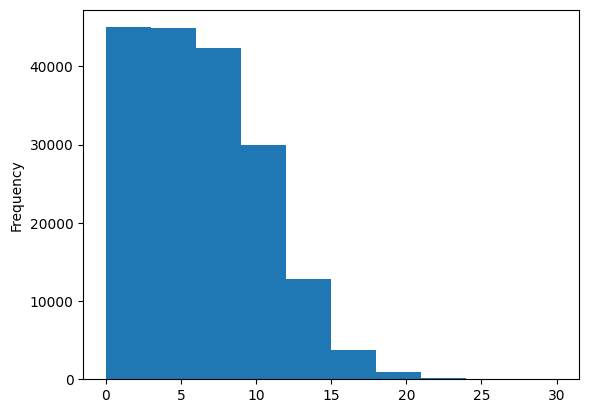

In [ ]:
# Check the distribution of "line_number" column
train_df["line_number"].plot.hist();

In [ ]:
#
# Use TensorFlow to create one-hot encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:13], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(13, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([

Now we've encoded our line number feature, let's do the same for our total lines feature...

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

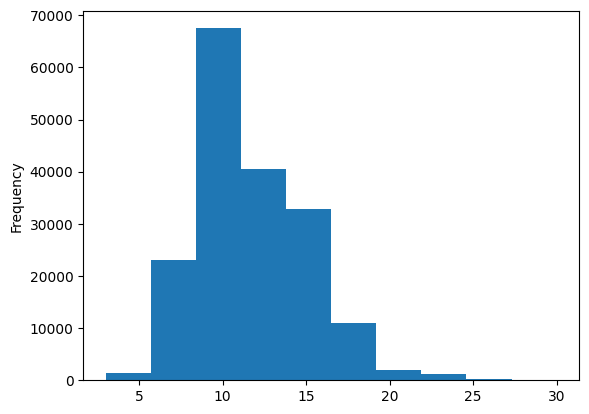

In [ ]:
# Check the distribution of "total_lines" column
train_df["total_lines"].plot.hist();

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df["total_lines"], 98)

20.0

In [ ]:
#
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:13], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(13, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4 & 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model`

In [ ]:
#
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Concatenate, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

# 1. Token inputs
token_inputs = Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embeddings)
token_model = Model(inputs=token_inputs,
                    outputs=token_outputs)

# 2. Char inputs
char_inputs = Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = Bidirectional(LSTM(24))(char_embeddings)
char_model = Model(inputs=char_inputs,
                   outputs=char_bi_lstm)

# 3. Line numbers model
line_numbers_inputs = Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
# dense layer with 32 units & relu activation
x = Dense(32, activation="relu")(line_numbers_inputs)
# combine inputs & dense layer into model
line_numbers_model = Model(inputs=line_numbers_inputs,
                           outputs=x)

# 4. Total lines
total_lines_inputs = Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
# dense layer with 32 units & relu activation
y = Dense(32, activation="relu")(total_lines_inputs)
# combine inputs & dense layer into model
total_lines_model = Model(inputs=total_lines_inputs,
                          outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                       char_model.output])
z = Dense(256, activation="relu")(combined_embeddings)
z = Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = Concatenate(name="char_token_positional_embedding")([line_numbers_model.output,
                                                                          total_lines_model.output,
                                                                          z])

# 7. Create output layer
output_layer = Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of outputs
model_5 = Model(inputs=[line_numbers_model.input,
                        total_lines_model.input,
                        token_model.input,
                        char_model.input],
                outputs=output_layer,
                name="model_5_tribrid_embedding_model")

In [ ]:
#
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   

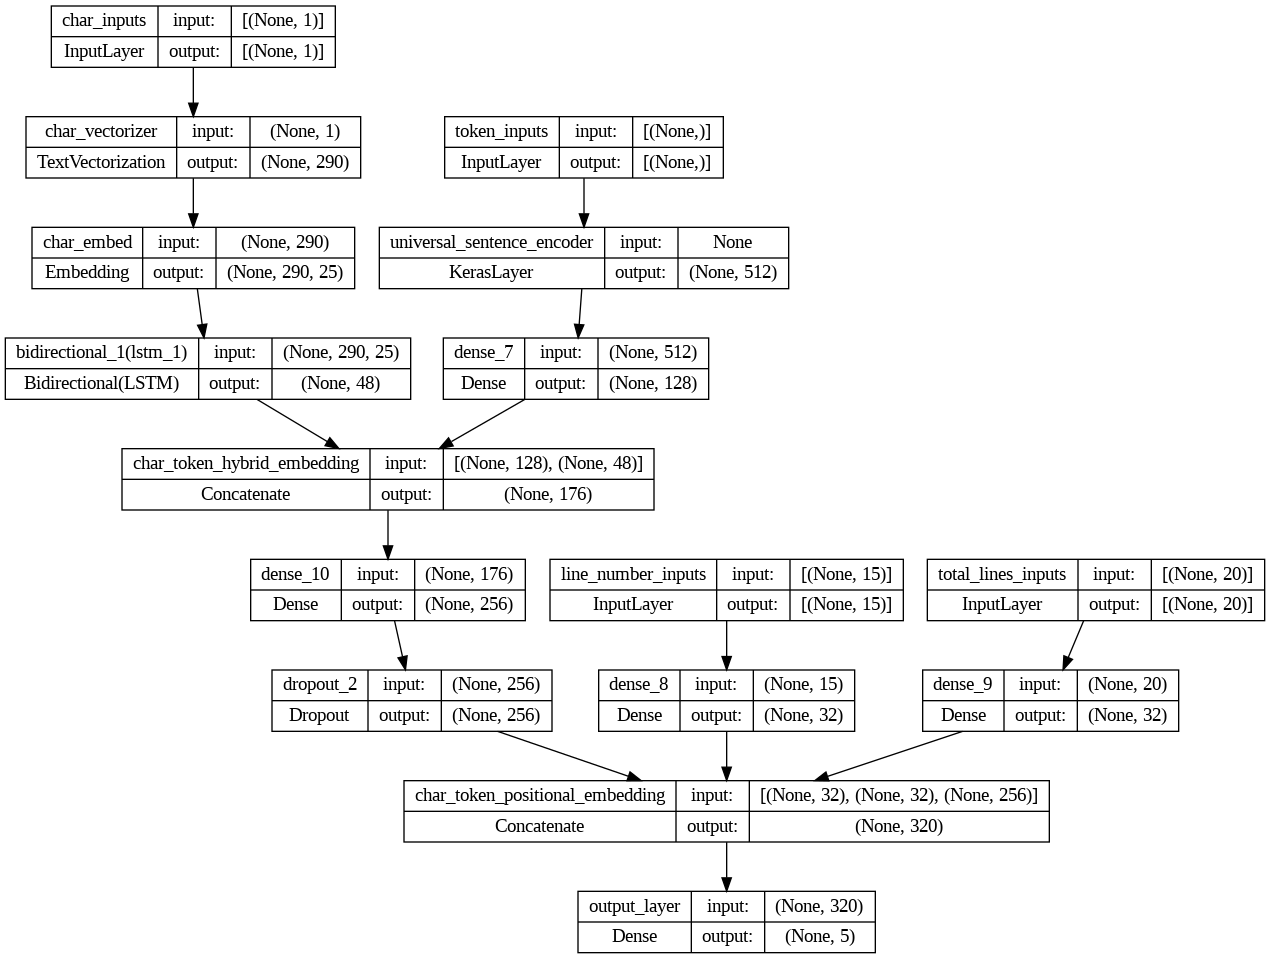

In [ ]:
#
# Plot model_5 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. it's prediction probability is really high), iy may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> 📖 **Resource:** For more on label smoothing, see this [blog post](https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/) from PyImageSearch


In [ ]:
#
# Compile token, char and postional embedding model
from tensorflow.keras.losses import CategoricalCrossentropy

model_5.compile(loss=CategoricalCrossentropy(label_smoothing=0.2),  # helps to prevent overfitting
                optimizer=Adam(),
                metrics=["accuracy"])

### Create tribing embedding datasets from `tf.data`

In [ ]:
#
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
#
saved_models_path = "/content/drive/MyDrive/Major Project/saved_models/"

In [ ]:
#
callback_model_5 = ModelCheckpoint(filepath=saved_models_path + "model_5",
                                   monitor="val_accuracy",
                                   save_best_only=True,
                                   mode="max")

In [ ]:
#
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                            #   steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              steps_per_epoch=len(train_char_token_pos_dataset),
                              epochs=10,
                              validation_data=val_char_token_pos_dataset,
                            #   validation_steps=int(0.1 * len(val_char_token_pos_dataset)))
                              validation_steps=len(val_char_token_pos_dataset),
                              callbacks=[callback_model_5])

Epoch 1/10
5627/5627 [==============================] - 356s 61ms/step - loss: 0.9516 - accuracy: 0.8251 - val_loss: 0.9070 - val_accuracy: 0.8498
Epoch 2/10
5627/5627 [==============================] - 330s 59ms/step - loss: 0.9076 - accuracy: 0.8554 - val_loss: 0.9002 - val_accuracy: 0.8535
Epoch 3/10
5627/5627 [==============================] - 322s 57ms/step - loss: 0.8955 - accuracy: 0.8638 - val_loss: 0.8968 - val_accuracy: 0.8555
Epoch 4/10
5627/5627 [==============================] - 318s 57ms/step - loss: 0.8867 - accuracy: 0.8702 - val_loss: 0.8976 - val_accuracy: 0.8551
Epoch 5/10
5627/5627 [==============================] - 320s 57ms/step - loss: 0.8797 - accuracy: 0.8750 - val_loss: 0.8977 - val_accuracy: 0.8556
Epoch 6/10
5627/5627 [==============================] - 297s 53ms/step - loss: 0.8740 - accuracy: 0.8800 - val_loss: 0.8972 - val_accuracy: 0.8544
Epoch 7/10
5627/5627 [==============================] - 286s 51ms/step - loss: 0.8692 - accuracy: 0.8831 - val_loss: 0

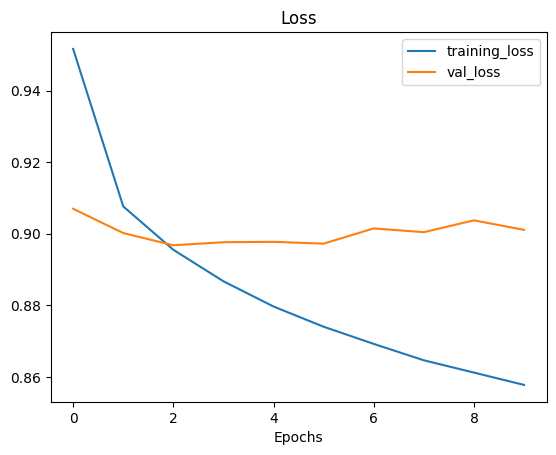

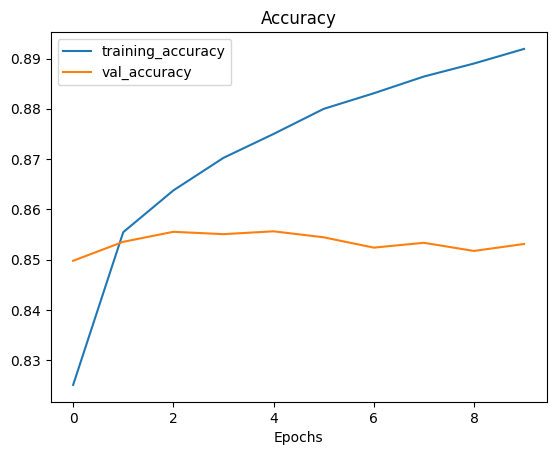

In [ ]:
#
plot_loss_curves(history_model_5)

In [ ]:
#
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 23s 21ms/step


array([[0.7242087 , 0.08064771, 0.01376797, 0.16682597, 0.01454968],
       [0.57913417, 0.09872296, 0.07249811, 0.21713135, 0.03251346],
       [0.3968614 , 0.07770571, 0.03058823, 0.4605137 , 0.03433096],
       ...,
       [0.02704699, 0.09707996, 0.02617774, 0.03577398, 0.8139213 ],
       [0.02977021, 0.3565346 , 0.03322559, 0.02890969, 0.5515599 ],
       [0.0401837 , 0.89324105, 0.02687885, 0.0284326 , 0.01126381]],
      dtype=float32)

In [ ]:
#
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
#
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.31047265987026,
 'precision': 0.8549308479841041,
 'recall': 0.8531047265987025,
 'f1': 0.8503839772545889}

## Compare model results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,76.856878,0.774085,0.768569,0.766982
model_2_pretrained_token_embedding,77.240831,0.770971,0.772408,0.768708
model_3_custom_char_embedding,67.953131,0.681255,0.679531,0.675456
model_4_hybrid_char_token_embedding,74.539918,0.743815,0.745399,0.739422
model_5_pos_char_token_embedding,85.310473,0.854931,0.853105,0.850384


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"] / 100

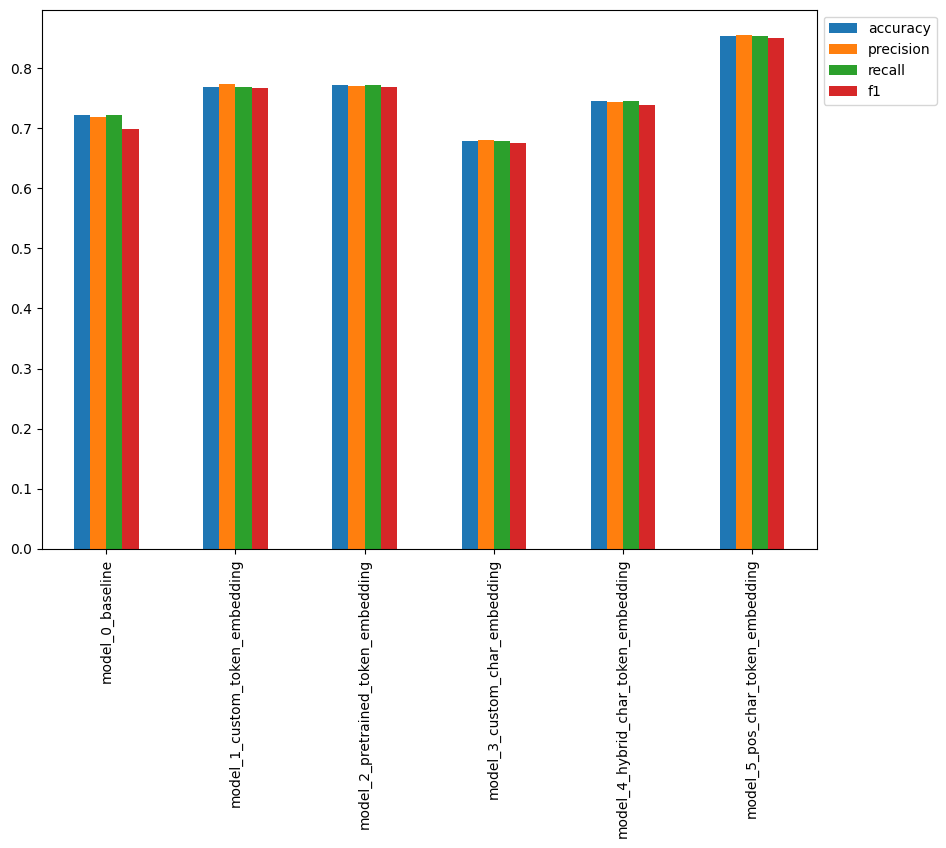

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

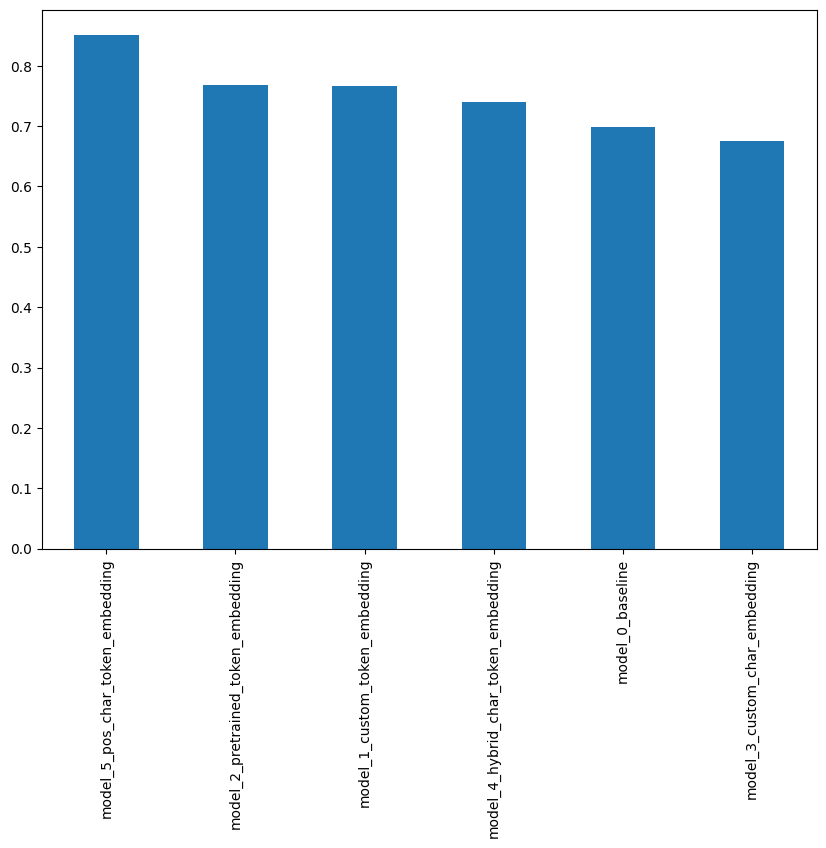

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and load best performing model

In [ ]:
#
# Load in the saved best-performing model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Major Project/saved_models/model_5")

## Make predictions with loaded model and compare with original model

In [ ]:
#
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 25s 23ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
#
# Calculate results of loaded model
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 85.56202833311268,
 'precision': 0.856995231077552,
 'recall': 0.8556202833311267,
 'f1': 0.8531972078293072}

In [ ]:
#
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()))

array([False, False, False, False])

In [ ]:
#
# Check a summary of loaded model to see number of trainable params
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   

## Evaluate model on test dataset

In [ ]:
#
# Create test dataset batch and prefetched
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
#
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_char_token_pos_dataset,)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 20s 22ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
#
# Calculate results of loaded model on test data
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 85.163431226149,
 'precision': 0.8516669809469869,
 'recall': 0.85163431226149,
 'f1': 0.8490429142437095}

### Find most wrong predictions

In [ ]:
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:10]

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.469963,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.594249,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.799355,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.775094,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.762527,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.853309,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.811062,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.704819,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.610360,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.666966,True


In [ ]:
# Find top 20 most wrong samples
top_20_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:20]
top_20_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
22736,OBJECTIVE,"the national institute of oncology , budapest ...",4,20,METHODS,0.959987,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.945412,False
4910,METHODS,response rates were @ % to @ % .,8,15,RESULTS,0.935991,False
19223,METHODS,"of the @ dogs receiving placebo , @ ( @ % ) vo...",7,10,RESULTS,0.934465,False
7870,METHODS,"a total of @,@ participants had three valid sy...",5,12,RESULTS,0.930595,False
6365,CONCLUSIONS,adverse events up to the third postoperative d...,7,8,RESULTS,0.919966,False
2755,CONCLUSIONS,"overall , the intervention enhanced health at ...",6,8,RESULTS,0.916244,False
20004,CONCLUSIONS,no treatment-related serious ae occurred .,10,11,RESULTS,0.916226,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.915408,False
14326,METHODS,a total of @ volunteer subjects were randomize...,6,13,RESULTS,0.912873,False


In [ ]:
# Investigate top wrong preds
for row in top_20_wrong[:10].itertuples():
    _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
    print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
    print(f"Text:\n{text}\n")
    print("-----\n")

Target: OBJECTIVE, Pred: METHODS, Prob: 0.9599867463111877, Line number: 4, Total lines: 20

Text:
the national institute of oncology , budapest conducted a single centre randomized clinical study .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9454116225242615, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9359908103942871, Line number: 8, Total lines: 15

Text:
response rates were @ % to @ % .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9344652891159058, Line number: 7, Total lines: 10

Text:
of the @ dogs receiving placebo , @ ( @ % ) vomited and @ ( @ % ) developed signs of nausea ; overall , @ of @ ( @ % ) dogs in the placebo treatment group vomited or developed signs of nausea .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9305948615074158, Line number: 5, Total lines: 12

Text:
a total of @,@ participants had three valid systolic readings , and @,@ had three valid diastolic readings .

-----

Target: CONCLUS

## Make example predictions

In [ ]:
# Download and open example abstracts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

import json

with open("skimlit_example_abstracts.json", "r") as f:
    example_abstracts = json.load(f)

example_abstracts

--2024-04-21 22:57:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-04-21 22:57:54 (75.3 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser
nlp.add_pipe("sentencizer") # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] = i
    sample_dict["total_lines"] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)

sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

In [ ]:
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]

In [ ]:
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 3s 3s/step


array([[0.3463456 , 0.11985404, 0.04152398, 0.4410995 , 0.05117693],
       [0.11050057, 0.05498428, 0.6507796 , 0.12157587, 0.06215965],
       [0.08408768, 0.03198915, 0.68159115, 0.10448116, 0.09785084],
       [0.07222535, 0.15578656, 0.6062994 , 0.06916555, 0.09652321],
       [0.04728901, 0.06313958, 0.15286018, 0.04726692, 0.6894443 ],
       [0.03947652, 0.08617395, 0.5609959 , 0.05458764, 0.25876597],
       [0.01490094, 0.03545789, 0.02190232, 0.01823186, 0.90950704],
       [0.01627383, 0.08862676, 0.07491617, 0.03188594, 0.7882973 ]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


In [ ]:
!pip install nbconvert

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-plain-generic is already the newest version (2021.20220204-1).
texlive-plain-generic set to manually installed.
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 209 not upgraded.


In [ ]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/Major_Project.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Major_Project.ipynb to pdf
[NbConvertApp] Support files will be in Major_Project_files/
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Making directory ./Major_Project_files
[NbConvertApp] Writing 26493